# EECE/CS 7268: Verifiable Machine Learning -- Fall 2025
# HW#2: Formal Verification

**Submission Instructions:** Please upload a .ipynb file (including your code, plots, and written answers) to Gradescope. This file can be updated unlimited times until the submission deadline.

 **Please provide your collaboration statement here or we will assign a zero on this assignment**:

$\Rightarrow$  I collaborate with Rana first. Gil also tell me what the question is about, so basically help me to understand questions faster!

## Libraries & Useful Functions

- `def nnet_to_weights_and_biases`(`nnet_filename`: str) -> tuple[np.ndarray, np.ndarray]:

  return Ws, bs


- `def weights_and_biases_to_pytorch`(`Ws`: list[np.ndarray], `bs`: list[np.ndarray]) -> torch.nn.Sequential:

  return torch.nn.Sequential(*layers[:-1])
  
  (don't add ReLU to end of NN)


- `def nnet_to_pytorch`(`nnet_filename`: str) -> torch.nn.Sequential:

  return weights_and_biases_to_pytorch(Ws, bs)


- `def model_to_weights_and_biases`(`model`: torch.nn.Sequential) -> tuple[np.ndarray, np.ndarray]:

  return Ws, bs


- `def nominal_and_epsilon_to_range`(`nominal`: np.ndarray, `epsilon`: np.ndarray | float) -> np.ndarray:

  return np.vstack(**[nominal-epsilon, nominal+epsilon]**).T


- `def range_to_nominal_and_epsilon`(`input_range`: np.ndarray) -> tuple[np.ndarray, np.ndarray]:

  return nominal_input, epsilon

In [1]:
import torch
import numpy as np
import cvxpy as cp
from enum import Enum
import matplotlib.pyplot as plt

In [2]:
def nnet_to_weights_and_biases(nnet_filename: str) -> tuple[np.ndarray, np.ndarray]:
  # load a nnet text file and extract the weights and biases

  # converted this code from: https://github.com/sisl/NeuralVerification.jl/blob/957cb32081f37de57d84d7f0813f708288b56271/src/utils/util.jl#L10
  with open(nnet_filename, 'r') as f:
    line = f.readline()
    while "//" in line: #skip comments
      line = f.readline()
    # number of layers
    nlayers = int(line.strip().split(",")[0])
    # read in layer sizes
    layer_sizes = [int(x) for x in f.readline().split(",")[1:nlayers+1]]
    # read past additonal information
    for i in range(1, 6):
      line = f.readline()
    # i=1 corresponds to the input dimension, so it's ignored
    Ws = []
    bs = []
    for dim in layer_sizes:
      W = np.vstack([[float(x) for x in f.readline().rstrip(',\n ').split(",")] for i in range(dim)])
      b = np.array([float(f.readline().rstrip(',\n ')) for _ in range(dim)])
      Ws.append(W)
      bs.append(b)

  return Ws, bs

def weights_and_biases_to_pytorch(Ws: list[np.ndarray], bs: list[np.ndarray]) -> torch.nn.Sequential:
  # given weights and biases, create a torch.nn.Sequential model with relus
  # btwn each linear layer (except no activation on final layer)

  num_layers = len(Ws)

  layers = []
  for W, b in zip(Ws, bs):
    out_features, in_features = W.shape
    layer = torch.nn.Linear(in_features, out_features)
    layer.weight = torch.nn.Parameter(torch.Tensor(W))
    layer.bias = torch.nn.Parameter(torch.Tensor(b))
    layers.append(layer)
    layers.append(torch.nn.ReLU())

  # don't add ReLU to end of NN
  model = torch.nn.Sequential(*layers[:-1])
  return model

def nnet_to_pytorch(nnet_filename: str) -> torch.nn.Sequential:
  # directly convert from nnet text file to pytorch model
  Ws, bs = nnet_to_weights_and_biases(nnet_filename)
  model = weights_and_biases_to_pytorch(Ws, bs)
  return model

def model_to_weights_and_biases(model: torch.nn.Sequential) -> tuple[np.ndarray, np.ndarray]:
  # extract the weights and biases as numpy arrays from a torch.nn.Sequential model
  Ws = []
  bs = []
  for idx, m in enumerate(model.modules()):
    if isinstance(m, torch.nn.Sequential):
      continue
    elif isinstance(m, torch.nn.ReLU):
      continue
    elif isinstance(m, torch.nn.Linear):
      Ws.append(m.weight.data.numpy())
      bs.append(m.bias.data.numpy())
    else:
      print("That layer isn't supported.")
      assert 0
  return Ws, bs

In [3]:
def nominal_and_epsilon_to_range(nominal: np.ndarray, epsilon: np.ndarray | float) -> np.ndarray:
  return np.vstack([nominal-epsilon, nominal+epsilon]).T

def range_to_nominal_and_epsilon(input_range: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
  nominal_input = (input_range[:, 1] + input_range[:, 0]) / 2.
  epsilon = (input_range[:, 1] - input_range[:, 0]) / 2.
  return nominal_input, epsilon

## Cartpole nnet(from my drive)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

# adjust the path to where you placed the file
nnet_filename = '/content/drive/MyDrive/cartpole_nnet.nnet'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
print("Cartpole Controller")

# Load the NNet file and pass a nominal input to get the class logits
cart_nominal_input = torch.Tensor([[0., 0.1, 0.2, 0.3]]) # these 4 values correspond to the 4 states in cartpole
cart_model = nnet_to_pytorch(nnet_filename)
cart_ws, cart_bs = model_to_weights_and_biases(cart_model)
cart_nominal_output = cart_model(cart_nominal_input)
print(f"{cart_nominal_output=}")

# Also set up an example set of possible inputs to this NN
cart_eps = 0.1 # epsilon can be a scalar or a vec w/ same shape as nominal_input
cart_input_range = nominal_and_epsilon_to_range(cart_nominal_input, cart_eps)
print(f"{cart_input_range=}")

Cartpole Controller
cart_nominal_output=tensor([[12.9007, -1.4208]], grad_fn=<AddmmBackward0>)
cart_input_range=array([[-0.1       ,  0.1       ],
       [ 0.        ,  0.2       ],
       [ 0.1       ,  0.3       ],
       [ 0.20000002,  0.4       ]], dtype=float32)


# Build pytorch model

In [6]:
Ws, bs = nnet_to_weights_and_biases(nnet_filename)
print(f'{Ws[:1]=}' + '\n '+ f'{bs[:1]=}\n')
m = weights_and_biases_to_pytorch(Ws, bs)
print(f'{m=}\n')
Ws, bs = model_to_weights_and_biases(m)
print(f'{Ws[:1]=}' + '\n '+ f'{bs[:1]=}\n')
model = nnet_to_pytorch(nnet_filename)
print(f'{model=}')

Ws[:1]=[array([[-1.043273  , -0.45572382,  0.1925421 ,  0.1925421 ],
       [-0.0191024 , -0.96924216,  0.15440625,  0.15440625],
       [-0.41816053,  0.37731004, -0.34120885, -0.34120885],
       [-0.5767956 , -0.5030595 ,  0.6254199 ,  0.6254199 ],
       [ 0.00491105, -0.3591427 , -0.17729259, -0.17729259],
       [-0.50836146, -0.33527863, -0.1795238 , -0.1795238 ],
       [-0.21825518, -0.28802422,  0.00792378,  0.00792378],
       [ 0.06058041, -0.04352689, -0.30520388, -0.30520388],
       [ 0.68546873,  2.4089003 , -1.5140697 , -1.5140697 ],
       [-0.48853403, -1.145808  , -1.7452701 , -1.7452701 ],
       [-2.3297534 , -1.7615417 ,  0.81776494,  0.81776494],
       [ 0.80140316, -1.3665487 , -1.204258  , -1.204258  ],
       [ 0.1973737 ,  0.4599561 , -0.34247142, -0.34247142],
       [-0.18949537, -0.27777648, -0.40307975, -0.40307975],
       [-0.04676789, -0.48210475,  0.11967127,  0.11967127],
       [ 0.04455786, -0.29007334, -0.38919103, -0.38919103]])]
 bs[:1]=[array

# Problem 1: Sampling-Based Under-Approximations

One way to approximate the set of possible NN outputs for a given set of possible NN inputs is by exhaustively sampling. Here, you will implement a simple sampling-based method for estimating the min and max values for each dimension of the NN output. This sampling-based strategy provides an under-approximation of the output set (and the corresponding rectangular bound is an under-approximation of the axis-aligned bounding box around the true output set).

The cartpole NN only has 4 inputs and 2 outputs, so you can visualize its output samples easily.

**Deliverables**:

- Implement the `output_range_sampling` function
- For the cartpole NN, plot your output samples and the corresponding rectangular bounds for a few different values of `num_samples`


### 1.1) Implement the `output_range_sampling` function

In [7]:
def output_range_sampling(nnet_filename: str, in_range: np.ndarray, num_samples: int, return_flag = False):

  model = nnet_to_pytorch(nnet_filename) # load model
  model.eval()

  lower_bound = in_range[:, 0] # lower bound
  upper_bound = in_range[:, 1] # upper bound
  #np.random.seed(0)
  lintf = np.random.uniform(low=lower_bound, high=upper_bound, size=(num_samples, lower_bound.shape[0]))
  lintf_t = torch.tensor(lintf, dtype=torch.float32)

  with torch.no_grad():
      out_t = model(lintf_t).numpy()

  min_max = np.stack([out_t.min(axis = 0), out_t.max(axis = 0)], axis=1)
  print(f'\n--- output_range_sampling ---')
  #print(f'{min_max=}')

  if return_flag:
    return min_max, lintf, out_t
  return min_max

# Test
samples_eps = 0.1
samples_input_range = nominal_and_epsilon_to_range(cart_nominal_input, samples_eps)
print(f'{samples_eps=}', f'{samples_input_range=}')
num_samples = int(10000)
output_range_sampling(nnet_filename, samples_input_range, num_samples)

samples_eps=0.1 samples_input_range=array([[-0.1       ,  0.1       ],
       [ 0.        ,  0.2       ],
       [ 0.1       ,  0.3       ],
       [ 0.20000002,  0.4       ]], dtype=float32)

--- output_range_sampling ---


array([[11.275918 , 15.93311  ],
       [-3.893023 , -1.0900686]], dtype=float32)

### 1.2) PLOT

In [8]:
def plot_samples(nnet_filename, plot_in_range, plot_sample_list, COLOR = 'green'):
  plot_model = nnet_to_pytorch(nnet_filename)
  plot_model.eval()

  for n in plot_sample_list:
    plot_min_max, plot_lintf, plot_out_t = output_range_sampling(nnet_filename, plot_in_range, n, True)
    print(f'\nN = {n} \nbounds = {plot_min_max}')

    plt.figure(figsize = (5, 5))
    plt.scatter(plot_out_t[:, 0], plot_out_t[:, 1], s = 1, alpha = 0.3)
    plot_x0, plot_x1 = plot_min_max[0,0], plot_min_max[0,1]
    plot_y0, plot_y1 = plot_min_max[1,0], plot_min_max[1,1]
    plt.plot([plot_x0, plot_x1, plot_x1, plot_x0, plot_x0],
             [plot_y0, plot_y0, plot_y1, plot_y1, plot_y0], color = COLOR)
    plt.title(f'(N = {n} ) output samples & rectangle')
    plt.xlabel('Left Action Logit')
    plt.ylabel('Right Action Logit')
    plt.show()

plot_eps =0.1 
 plot_input_range=array([[-0.1       ,  0.1       ],
       [ 0.        ,  0.2       ],
       [ 0.1       ,  0.3       ],
       [ 0.20000002,  0.4       ]], dtype=float32)

--- output_range_sampling ---

N = 100 
bounds = [[11.976879  15.309418 ]
 [-3.0536098 -1.1331546]]


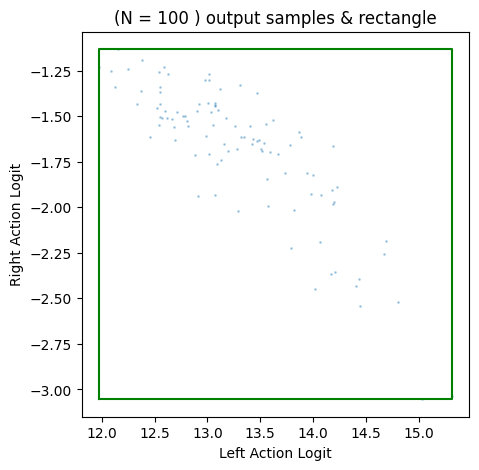


--- output_range_sampling ---

N = 1000 
bounds = [[11.585449  15.91875  ]
 [-3.7488818 -1.1423812]]


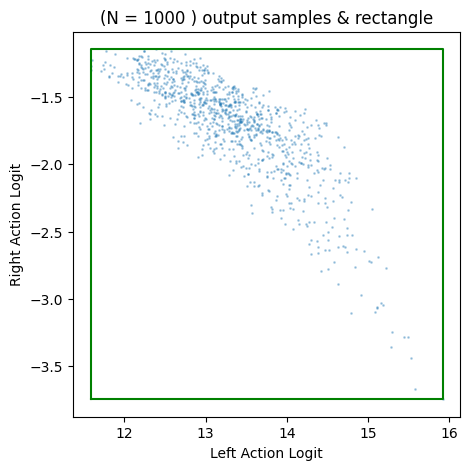


--- output_range_sampling ---

N = 5000 
bounds = [[11.389375  16.337317 ]
 [-4.2760663 -1.0914845]]


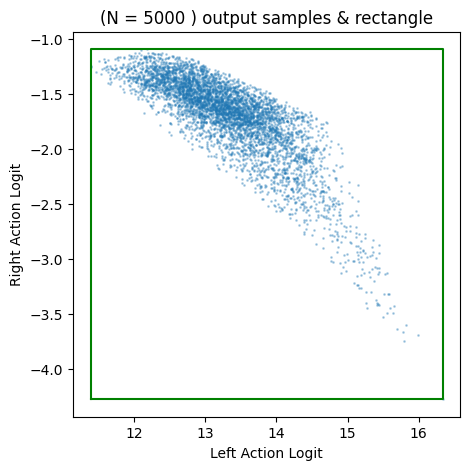


--- output_range_sampling ---

N = 10000 
bounds = [[11.303189  15.893674 ]
 [-3.958475  -1.0947082]]


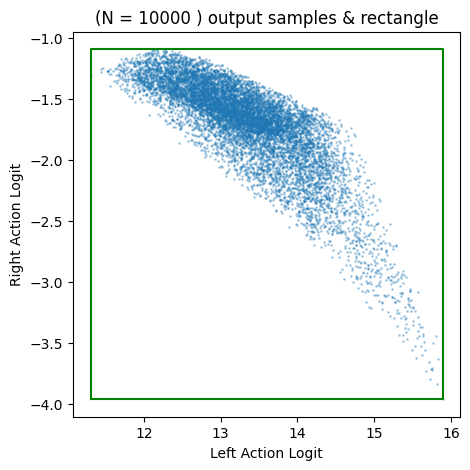


--- output_range_sampling ---

N = 50000 
bounds = [[11.311406  16.16208  ]
 [-4.08267   -1.0952551]]


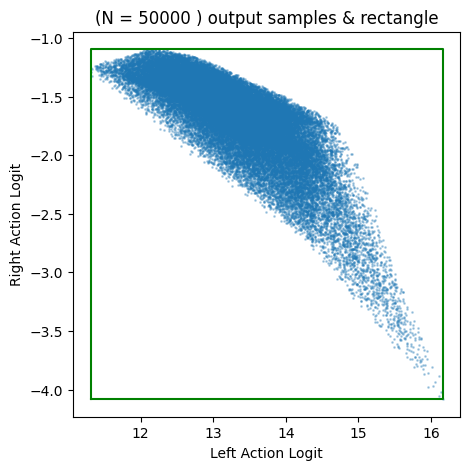


--- output_range_sampling ---

N = 100000 
bounds = [[11.2205515 16.274593 ]
 [-4.2316    -1.0958741]]


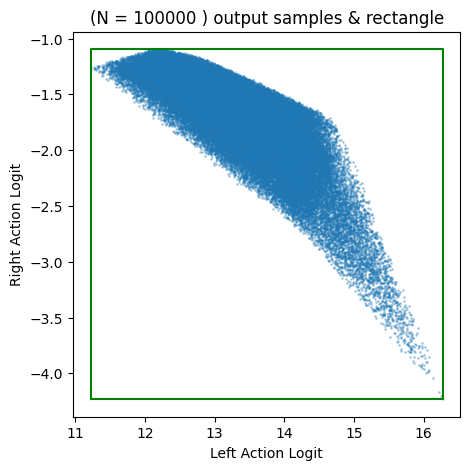

In [9]:
plot_eps = 0.1 # epsilon can be a scalar or a vec w/ same shape as nominal_input
plot_input_range = nominal_and_epsilon_to_range(cart_nominal_input, plot_eps)
print(f'{plot_eps =} \n {plot_input_range=}')
plot_samples(nnet_filename, plot_input_range, [100, 1000, 5000, 10000, 50000, 100000])

# Problem 2: Interval Bound Propagation (IBP)

Now, you will implement the IBP algorithm to get *outer* bounds on the output set -- which are much more useful for proving that the NN will not produce undesired outputs. You may want to read [the IBP paper](https://arxiv.org/pdf/1810.12715.pdf) (especially around Eqn 6) to help with this.

**Deliverables:**

- Implement the `verify_ibp` function
- Print the `output_range` from your IBP implementation
- Plot your IBP rectangular bounds along with the samples from above to see how ridiculously loose IBP bounds can be

## 2.1) IMPLEMENT the `verify_ibp` function

In [10]:
def verify_ibp(nnet_filename: str, ibp_in_range: np.ndarray):

  print('--- verify_ibp ---')

  ibp_ws, ibp_bs = nnet_to_weights_and_biases(nnet_filename)

  ibp_z_lowbar_kprev = ibp_in_range[:, 0] # lowbar z0 = x0 - ϵ1
  ibp_z_upbar_kprev = ibp_in_range[:, 1] # upbar z0 = x0 + ϵ1

  for i in range(len(ibp_ws) - 1): # without the last layer

    ibp_w, ibp_b = ibp_ws[i], ibp_bs[i]

    ibp_mu_kprev = ( ibp_z_upbar_kprev + ibp_z_lowbar_kprev )/ 2  # center
    ibp_r_kprev = ( ibp_z_upbar_kprev - ibp_z_lowbar_kprev )/ 2  # radius

    ibp_mu_k = ibp_w @ ibp_mu_kprev + ibp_b
    ibp_r_k = np.abs(ibp_w) @ ibp_r_kprev

    ibp_z_upbar_k = ibp_mu_k + ibp_r_k # pre 上界
    ibp_z_lowbar_k = ibp_mu_k - ibp_r_k # pre 下界

    ibp_z_upbar_kprev = np.maximum(ibp_z_upbar_k, 0) # ReLU(pre下界)
    ibp_z_lowbar_kprev = np.maximum(ibp_z_lowbar_k, 0) # ReLU(pre上界)

  # the last layer
  ibp_w_last, ibp_b_last = ibp_ws[i+1], ibp_bs[i+1]

  ibp_mu_kprev = ( ibp_z_upbar_kprev + ibp_z_lowbar_kprev )/ 2  # center
  ibp_r_kprev = ( ibp_z_upbar_kprev - ibp_z_lowbar_kprev )/ 2  # radius

  ibp_mu_k = ibp_w_last @ ibp_mu_kprev + ibp_b_last
  ibp_r_k = np.abs(ibp_w_last) @ ibp_r_kprev

  ibp_z_upbar_k = ibp_mu_k + ibp_r_k
  ibp_z_lowbar_k = ibp_mu_k - ibp_r_k

  '''
  print('- ibp bound:')
  print(f'{ibp_z_upbar_k= }')
  print(f'{ibp_z_lowbar_k= }\n')
  '''
  return ibp_z_lowbar_k, ibp_z_upbar_k

# Test
ibp_plot_eps = 0.1 # epsilon can be a scalar or a vec w/ same shape as nominal_input
ibp_input_range = nominal_and_epsilon_to_range(cart_nominal_input, ibp_plot_eps)
ibp_output_range = verify_ibp(nnet_filename, ibp_input_range)
print(f"{ibp_output_range=}")

--- verify_ibp ---
ibp_output_range=(array([-25.60730514, -32.45794935]), array([52.51911865, 23.75044591]))


## 2.2) Print the `output_range` from (2.1)
I try different epsilon value from 0.05 to 0.3 below

In [11]:
ibp_print_eps = np.array([0.05, 0.1, 0.2, 0.3])

for e in range(len(ibp_print_eps)):

  ibp_print_input_range = nominal_and_epsilon_to_range(cart_nominal_input, ibp_print_eps[e])
  print(f'{e=}', ' ', f'{ibp_print_input_range=}')

  ibp_print_output_range = verify_ibp(nnet_filename, ibp_print_input_range)
  #print(f'{output_range_ibp.shape=}')
  print(f'{ibp_print_output_range=}\n\n')

e=0   ibp_print_input_range=array([[-0.05      ,  0.05      ],
       [ 0.05      ,  0.15      ],
       [ 0.15      ,  0.25      ],
       [ 0.25      ,  0.35000002]], dtype=float32)
--- verify_ibp ---
ibp_print_output_range=(array([ -1.05745466, -15.22126055]), array([30.31776224,  9.7058196 ]))


e=1   ibp_print_input_range=array([[-0.1       ,  0.1       ],
       [ 0.        ,  0.2       ],
       [ 0.1       ,  0.3       ],
       [ 0.20000002,  0.4       ]], dtype=float32)
--- verify_ibp ---
ibp_print_output_range=(array([-25.60730514, -32.45794935]), array([52.51911865, 23.75044591]))


e=2   ibp_print_input_range=array([[-0.2       ,  0.2       ],
       [-0.1       ,  0.3       ],
       [ 0.        ,  0.4       ],
       [ 0.10000001,  0.5       ]], dtype=float32)
--- verify_ibp ---
ibp_print_output_range=(array([-81.83013197, -73.95964326]), array([107.45174852,  56.76783614]))


e=3   ibp_print_input_range=array([[-0.3       ,  0.3       ],
       [-0.20000002,  0.4       

## 2.3) PLOT IBP rectangule

In [12]:
def plot_rect(min_x, max_x, min_y, max_y, coloring = 'orange', linwid = 2):
  plt.plot([min_x, max_x, max_x, min_x, min_x],
           [min_y, min_y, max_y, max_y, min_y],
           color = coloring, linewidth = linwid)

In [13]:
def plot_format(Title, Xlabel = 'Left Action Logit', Ylabel = 'Right Action Logit'):
  plt.title(Title)
  plt.xlabel(Xlabel)
  plt.ylabel(Ylabel)
  plt.grid(True)

In [14]:
def plot_ibp(nnet_filename, in_range, plot_eps, sample_numbers=None):

    ibp_low, ibp_up = verify_ibp(nnet_filename, in_range)

    outs = None
    if sample_numbers is not None and sample_numbers > 0:
        ibplot_samp_minmax, _, outs = output_range_sampling(nnet_filename, in_range, sample_numbers, True)

    plt.figure(figsize = (6, 6))

    if outs is not None: # plot samples
        plt.scatter(outs[:,0], outs[:,1], s = 0.1, alpha = 0.3)
    # sample bound
    if outs is not None:
        plot_rect(ibplot_samp_minmax[0,0], ibplot_samp_minmax[0,1], ibplot_samp_minmax[1,0], ibplot_samp_minmax[1,1], 'green', 1)

    # ibp bound
    plot_rect(ibp_low[0], ibp_up[0], ibp_low[1], ibp_up[1], 'blue', 2)

    plot_format(f'epsilon: {plot_eps} IBP output bounds' + (' + samples' if outs is not None else ''))


### FIXED sample=1000, change eps =[0.05, 0.1, 0.2, 0.3]

--- verify_ibp ---
--- verify_ibp ---

--- output_range_sampling ---


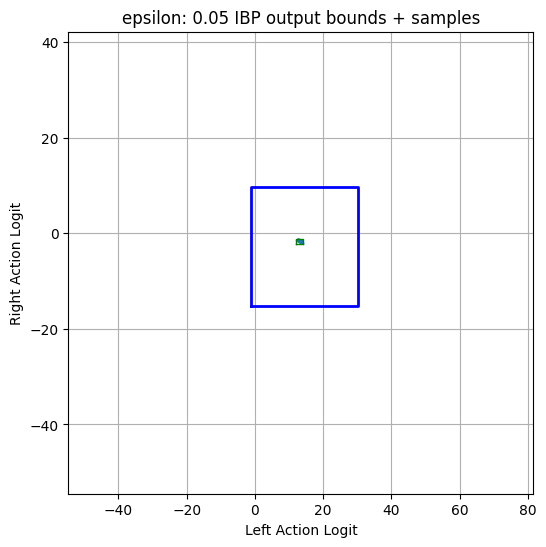

--- verify_ibp ---

--- output_range_sampling ---


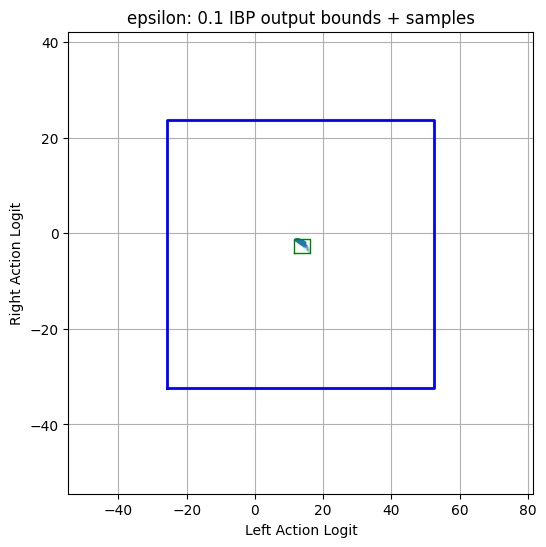

--- verify_ibp ---

--- output_range_sampling ---


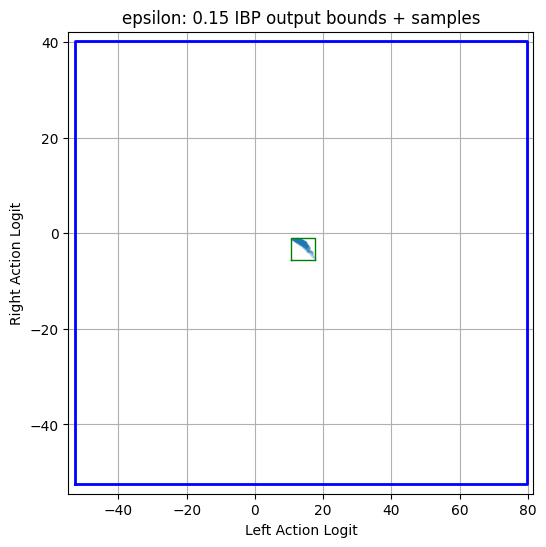

In [15]:
ibp_eps = np.array([0.05, 0.1, 0.15])
max_eps = max(ibp_eps)

ibp_in_range_glob = nominal_and_epsilon_to_range(cart_nominal_input, max_eps)
ibp_low_glob, ibp_up_glob = verify_ibp(nnet_filename, ibp_in_range_glob)
xlim = (ibp_low_glob[0]-2, ibp_up_glob[0]+2)
ylim = (ibp_low_glob[1]-2, ibp_up_glob[1]+2)

for i in range(len(ibp_eps)):
  plot_ibp(nnet_filename, nominal_and_epsilon_to_range(cart_nominal_input, ibp_eps[i]), ibp_eps[i], 1000)
  plt.xlim(xlim)
  plt.ylim(ylim)
  plt.show()

### FIXED epsilon = 0.1 , change sample=[100, 500, 1000, 5000, 10000, 50000, 100000]

--- verify_ibp ---
--- verify_ibp ---

--- output_range_sampling ---


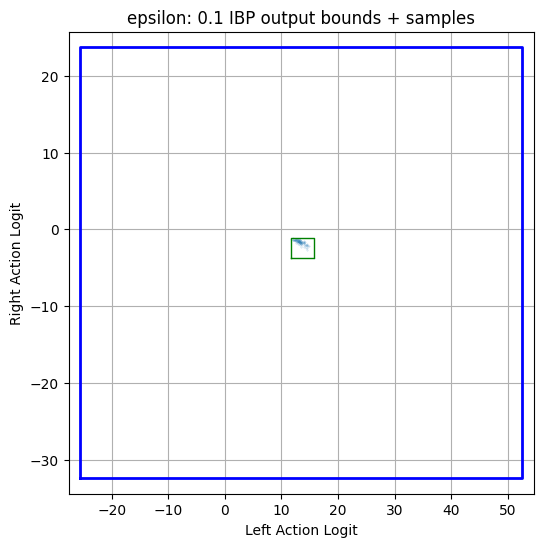

--- verify_ibp ---

--- output_range_sampling ---


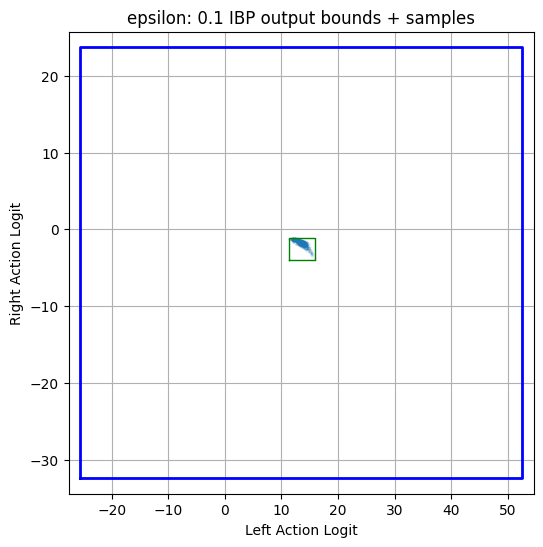

--- verify_ibp ---

--- output_range_sampling ---


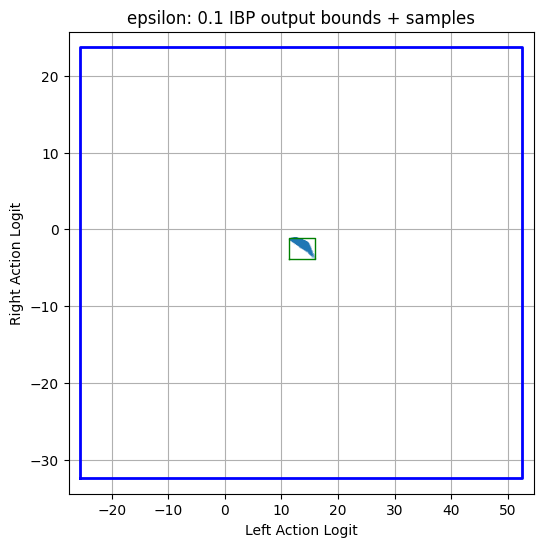

--- verify_ibp ---

--- output_range_sampling ---


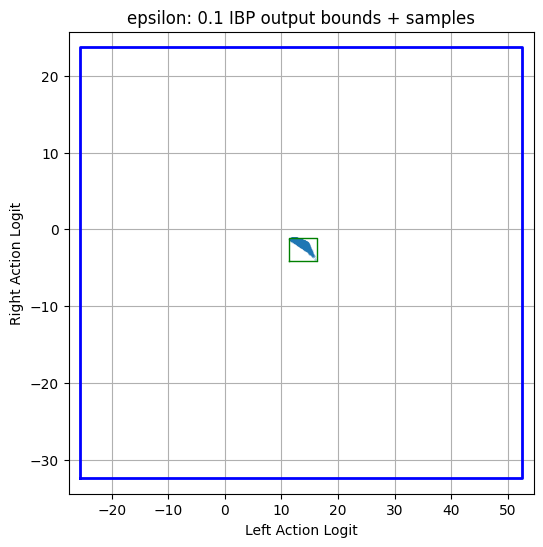

--- verify_ibp ---

--- output_range_sampling ---


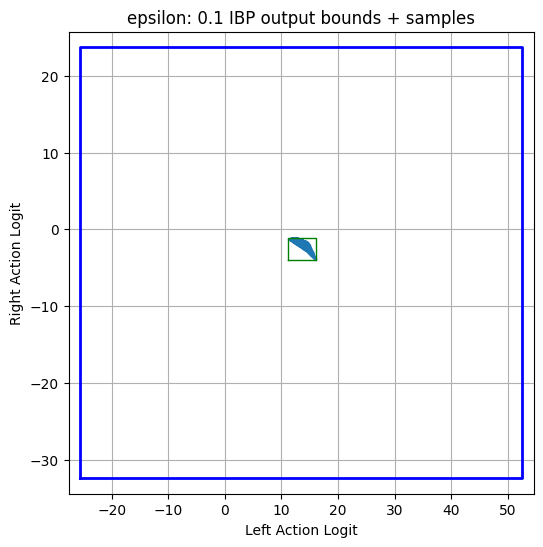

--- verify_ibp ---

--- output_range_sampling ---


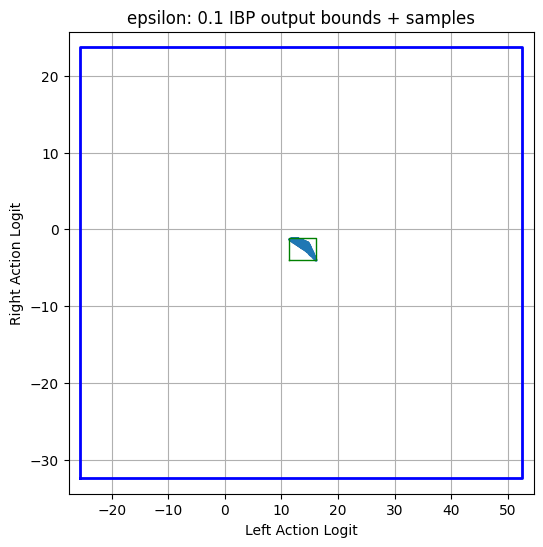

In [16]:
# set up an example set of possible inputs to this NN
ibp2_eps = 0.1
ibp2_samples = [100, 1000, 5000, 10000, 50000, 100000]

ibp2_in_range_glob = nominal_and_epsilon_to_range(cart_nominal_input, ibp2_eps)
ibp2_low_glob, ibp2_up_glob = verify_ibp(nnet_filename, ibp2_in_range_glob)
ibp2_xlim = (ibp2_low_glob[0]-2, ibp2_up_glob[0]+2)
ibp2_ylim = (ibp2_low_glob[1]-2, ibp2_up_glob[1]+2)

ibp2_max_samples = max(ibp2_samples)

for i in range(len(ibp2_samples)):
  plot_ibp(nnet_filename, nominal_and_epsilon_to_range(cart_nominal_input, ibp2_eps), ibp2_eps, ibp2_samples[i])
  plt.xlim(ibp2_xlim)
  plt.ylim(ibp2_ylim)
  plt.show()


# Problem 3: Linear Program (LP)

Since IBP's bounds are usually too loose to say something useful about the NN's output set, you will now implement an LP-based verification algorithm that should provide much tighter bounds while remaining computationally reasonable.

You will set up an LP (e.g., using `cvxpy` to set up variables, constraints, and objectives corresponding to the NN verification problem) for each side of the rectangle (i.e., min & max per output dimension, which can be done by simply changing the objective). To turn the ReLU constraints into linear equality/inequality constraints, you can check which neurons are "active", "inactive", or "uncertain" and add the corresponding relaxed constraints. To know which neurons belong to which category, you will need to acquire intermediate bounds -- there are lots of ways to do this!

In [17]:
def verify_lp(nnet_filename: str, lp_in_range: np.ndarray) -> np.ndarray:

  lp_ws, lp_bs = nnet_to_weights_and_biases(nnet_filename)

  lp_n_layers = len(lp_ws)
  lp_n_in = lp_in_range.shape[0]
  lp_n_out = lp_ws[-1].shape[0]


  lp_z_post_act = []
  lp_z_post_act.append(cp.Variable(lp_n_in)) # Input layer
  for i in range(lp_n_layers - 1): # Hidden layer
    lp_z_post_act.append(cp.Variable(lp_ws[i].shape[0]))
  lp_z_post_act.append(cp.Variable(lp_n_out)) # Output layer (no ReLU)

  lp_constraints = []
  lp_constraints.append(lp_z_post_act[0] >= lp_in_range[:, 0])
  lp_constraints.append(lp_z_post_act[0] <= lp_in_range[:, 1])

  lp_z_lowbar_kprev = lp_in_range[:, 0] # lowbar z0 = x0 - ϵ1
  lp_z_upbar_kprev = lp_in_range[:, 1] # upbar z0 = x0 + ϵ1

  for i in range(len(lp_ws) - 1):         # without the last layer

    lp_w, lp_b = lp_ws[i], lp_bs[i]

    lp_mu_kprev = ( lp_z_upbar_kprev + lp_z_lowbar_kprev )/ 2  # center
    lp_r_kprev = ( lp_z_upbar_kprev - lp_z_lowbar_kprev )/ 2  # radius

    lp_mu_k = lp_w @ lp_mu_kprev + lp_b
    lp_r_k = np.abs(lp_w) @ lp_r_kprev

    lp_z_upbar_k = lp_mu_k + lp_r_k
    lp_z_lowbar_k = lp_mu_k - lp_r_k

    pre_act = lp_w @ lp_z_post_act[i] + lp_b

    for j in range(len(lp_z_upbar_k)): # [l, u]
      lp_up = lp_z_upbar_k[j]
      lp_low = lp_z_lowbar_k[j]

      if lp_low >= 0: # active
        lp_constraints.append(lp_z_post_act[i+1][j] == pre_act[j])
      elif lp_up <= 0: # inactive
        lp_constraints.append(lp_z_post_act[i+1][j] == 0)
      else: # unsure
        lp_constraints.append(lp_z_post_act[i+1][j] >= 0) # z >= 0
        lp_constraints.append(lp_z_post_act[i+1][j] >= pre_act[j]) # z >= pre_activation
        lp_constraints.append(lp_z_post_act[i+1][j] <= (lp_up/(lp_up-lp_low)) * (pre_act[j]-lp_low) ) # z <= u/(u-l) * (pre_activation - l)

    lp_z_upbar_kprev = np.maximum(lp_z_upbar_k, 0)
    lp_z_lowbar_kprev = np.maximum(lp_z_lowbar_k, 0)

  lp_w_last, lp_b_last = lp_ws[-1], lp_bs[-1]
  lp_constraints.append(lp_z_post_act[-1] == lp_w_last @ lp_z_post_act[-2] + lp_b_last)


  lp_out_range = np.zeros((lp_n_out, 2))

  for k in range(lp_n_out):

    # find Minima
    lp_prob_min = cp.Problem(cp.Minimize(lp_z_post_act[-1][k]), lp_constraints)
    lp_out_min = lp_prob_min.solve(solver=cp.HIGHS)
    lp_out_range[k, 0] = lp_out_min

    # find Maxima
    lp_prob_max = cp.Problem(cp.Maximize(lp_z_post_act[-1][k]), lp_constraints)
    lp_out_max = lp_prob_max.solve(solver=cp.HIGHS)
    lp_out_range[k, 1] = lp_out_max

  return lp_out_range

#verify_lp(nnet_filename, input_range)
output_range_lp = verify_lp(nnet_filename, cart_input_range)
print(f'{output_range_lp=}')

output_range_lp=array([[  0.4976209 ,  25.70728002],
       [-11.84320993,   5.98689137]])


# Problem 4: Verify Classifier Robustness

So far, you have written verification algorithms that provide upper and lower bounds on each output of the NN. Here, you will slightly modify your LP verifier so that it verifies the *robustness* of a *classifier* (i.e., prove that the classifier predicts the same class for every input within some range).

If the verification algorithm is able to prove robustness, you should return `VerifierResults.Robust`. If the verification algorithm is unable to prove robustness, you should return `VerifierResults.Unsure` (remember that this doesn't necessarily mean the classifier isn't robust, just that our algorithm failed to find a proof). I also added a `VerifierResults.Timeout` option, because you will often see this in real verification algorithms, but you do not need to use this here.

To start, you can pretend the cartpole controller was a classifier and try to see how large of an epsilon you can specify until you can't verify the robustness anymore.

Then, you can load an MNIST classifier (code below) and try to see how large of an epsilon for which you can still verify robustness around a nominal image. Since the MNIST classifier is a way bigger NN, there will be some impact on the runtime of your LP.

**Deliverables:**

- Implement `verify_classification_robustness_lp`
- Plot and/or briefly describe your findings w.r.t. robustness verification as you increase epsilon for the cartpole controller
- Plot and/or briefly describe your findings w.r.t. robustness verification as you increase epsilon for the MNIST classifier

In [18]:
class VerifierResults(Enum):
  Robust = 0
  Unsure = 1
  Timeout = 2

def verify_classification_robustness_lp(nnet_filename: str, rob_in_range: np.ndarray) -> int:

  rob_cent_in = (rob_in_range[:, 0] + rob_in_range[:, 1]) / 2
  rob_model = nnet_to_pytorch(nnet_filename)
  rob_model.eval()
  with torch.no_grad():
      rob_output = rob_model(torch.tensor(rob_cent_in))
      pred_class = torch.argmax(rob_output)

  rob_out_bounds = verify_lp(nnet_filename, rob_in_range)

  pred_low = rob_out_bounds[pred_class, 0]

  for i in range(rob_out_bounds.shape[0]):
      if i != pred_class:
          other_upper = rob_out_bounds[i, 1]
          if other_upper >= pred_low:
              return VerifierResults.Unsure

  return VerifierResults.Robust

verifier_result = verify_classification_robustness_lp(nnet_filename, cart_input_range)
verifier_result

<VerifierResults.Unsure: 1>

## Test Cartpole

Test Cartpole Controller Robustness
Testing ε = e = 0.01
Robust
Testing ε = e = 0.05
Robust
Testing ε = e = 0.08
Robust
Testing ε = e = 0.09
Unsure
Testing ε = e = 0.1
Unsure
Testing ε = e = 0.15
Unsure
Testing ε = e = 0.2
Unsure
Testing ε = e = 0.25
Unsure


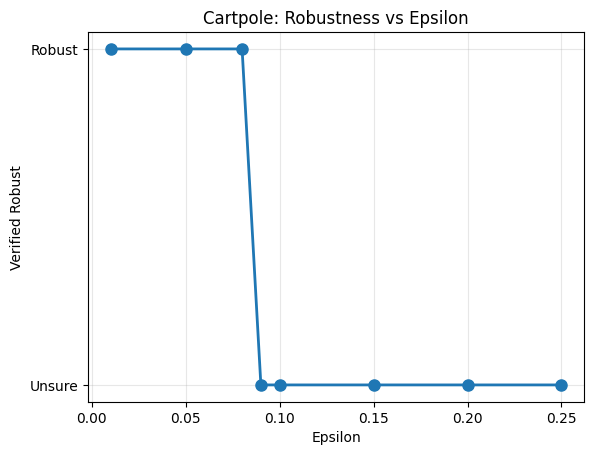

In [19]:
print("Test Cartpole Controller Robustness")

rob_eps_list = [0.01, 0.05, 0.08, 0.09, 0.1, 0.15, 0.2, 0.25]
cartpole_results = []

for e in rob_eps_list:
    print(f'Testing ε = {e = }')
    rob_input_range = nominal_and_epsilon_to_range(cart_nominal_input, e)
    rob_result = verify_classification_robustness_lp(nnet_filename, rob_input_range)
    cartpole_results.append((e, rob_result))
    print(f"{VerifierResults(rob_result).name}")

eps_vals = []
robust_vals = []

for epsilon, result in cartpole_results:
    eps_vals.append(epsilon)
    robust_vals.append(1 if result == VerifierResults.Robust else 0)

plt.plot(eps_vals, robust_vals, 'o-', linewidth = 2, markersize = 8)
plt.xlabel('Epsilon')
plt.ylabel('Verified Robust')
plt.title('Cartpole: Robustness vs Epsilon')
plt.yticks([0, 1], ['Unsure', 'Robust'])
plt.grid(True, alpha=0.3)
plt.show()

Load a NN classifier for MNIST, then query the model at a particular image:

In [20]:
print('MNIST Classifier')

# Load the NNet file and pass a nominal input to get the class logits
nnet_filename_mnist = '/content/drive/MyDrive/mnist1.nnet'

from tensorflow.keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
img_index = 2 # this one should be correctly classified as a 4...
nominal_input_mnist = torch.Tensor(x_train[img_index].flatten())
model_mnist = nnet_to_pytorch(nnet_filename_mnist)
Ws_mnist, bs_mnist = model_to_weights_and_biases(model_mnist)
nominal_output = model_mnist(nominal_input_mnist)
nominal_class = nominal_output.argmax()
print(f"{nominal_output=}")
print(f"Predicted Class: {nominal_class}, True Class: {y_train[img_index]}")

# Also set up an example set of possible inputs to this NN

epsilon_mnist = 2*np.ones((784))
input_range_mnist = nominal_and_epsilon_to_range(nominal_input_mnist, epsilon_mnist)
print(f"{input_range_mnist=}")

MNIST Classifier
nominal_output=tensor([ -130.8385, -1543.3896,   131.6747,   348.4880,   987.1154, -1114.0826,
         -638.6053,   216.2303,   -85.5050,   418.8903],
       grad_fn=<ViewBackward0>)
Predicted Class: 4, True Class: 4
input_range_mnist=array([[-2.,  2.],
       [-2.,  2.],
       [-2.,  2.],
       ...,
       [-2.,  2.],
       [-2.,  2.],
       [-2.,  2.]])


Test MNIST Classifier Robustness
Testing ε = eps = 0.5
VerifierResults.Robust
Testing ε = eps = 1.0
VerifierResults.Robust
Testing ε = eps = 1.5
VerifierResults.Robust
Testing ε = eps = 2.0
VerifierResults.Robust
Testing ε = eps = 2.5
VerifierResults.Robust
Testing ε = eps = 2.6
VerifierResults.Robust
Testing ε = eps = 2.7
VerifierResults.Robust
Testing ε = eps = 2.8
VerifierResults.Robust
Testing ε = eps = 2.85
VerifierResults.Unsure
Testing ε = eps = 2.9
VerifierResults.Unsure
Testing ε = eps = 3.0
VerifierResults.Unsure
Testing ε = eps = 3.5
VerifierResults.Unsure


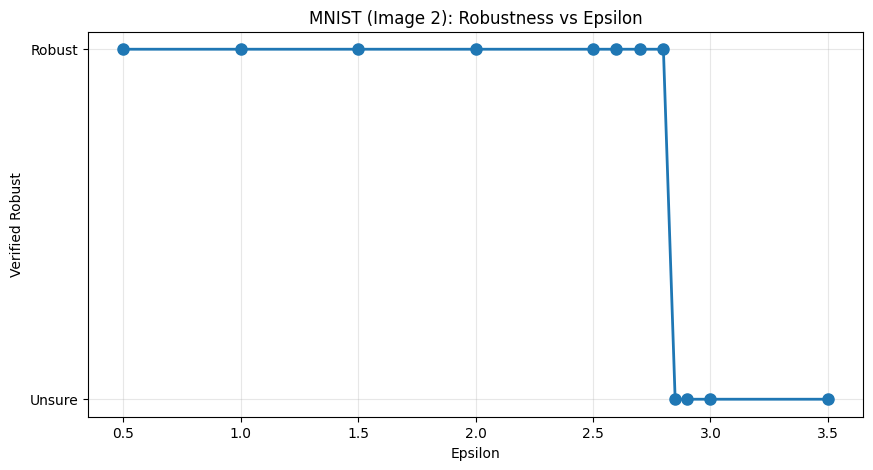

In [21]:
print("Test MNIST Classifier Robustness")

minst_eps_list = [0.5, 1.0, 1.5, 2.0, 2.5, 2.6, 2.7, 2.8, 2.85, 2.9, 3.0, 3.5]
mnist_results = []

for eps in minst_eps_list:
    print(f'Testing ε = {eps = }')
    eps_vector = eps * np.ones(784)
    input_range = nominal_and_epsilon_to_range(nominal_input_mnist, eps_vector)

    result = verify_classification_robustness_lp(nnet_filename_mnist, input_range.astype(np.float32))
    mnist_results.append((eps, result))
    print(f"{VerifierResults(result)}")

plt.figure(figsize = (10, 5))

eps_vals = []
robust_vals = []

for e, result in mnist_results:
    eps_vals.append(e)
    robust_vals.append(1 if result == VerifierResults.Robust else 0)

plt.plot(eps_vals, robust_vals, 'o-', linewidth=2, markersize=8)
plt.xlabel('Epsilon')
plt.ylabel('Verified Robust')
plt.title(f'MNIST (Image {img_index}): Robustness vs Epsilon')
plt.yticks([0, 1], ['Unsure', 'Robust'])
plt.grid(True, alpha=0.3)
plt.show()

# Problem 5: Explore the `jax_verify` library for verification

In [22]:
# Install my fork of jax_verify, which fixes a few deprecation errors in the mainline repopip
!pip install git+https://gitlab.com/neu-autonomy/certifiable-learning/jax_verify@c9dedb6a60a84a9262d07d1a7efa67106649ece8

  Cloning https://gitlab.com/neu-autonomy/certifiable-learning/jax_verify (to revision c9dedb6a60a84a9262d07d1a7efa67106649ece8) to /tmp/pip-req-build-i4eugpdu
  Running command git clone --filter=blob:none --quiet https://gitlab.com/neu-autonomy/certifiable-learning/jax_verify /tmp/pip-req-build-i4eugpdu
  Running command git rev-parse -q --verify 'sha^c9dedb6a60a84a9262d07d1a7efa67106649ece8'
  Running command git fetch -q https://gitlab.com/neu-autonomy/certifiable-learning/jax_verify c9dedb6a60a84a9262d07d1a7efa67106649ece8
  Resolved https://gitlab.com/neu-autonomy/certifiable-learning/jax_verify to commit c9dedb6a60a84a9262d07d1a7efa67106649ece8
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/deepmind/einshape.git to /tmp/pip-install-9v3ws960/einshape_c321ea610bc54255b050f003362de218
  Running command git clone --filter=blob:none --quiet https://github.com/deepmind/einshape.git /tmp/pip-install-9v3ws960/einshape_c321ea610bc54255b050f003362de218
  Resolved ht

In [23]:
import jax.numpy as jnp
import jax_verify
import functools

Some utility methods that help set up the NN in jax:

In [24]:
def pytorch_model_to_jax(torch_model: torch.nn.Sequential):
  params = []
  act = None

  # Extract params (weights, biases) from torch layers, to be used in
  # jax.
  # Note: This propagator assumes a feed-forward relu NN.
  for m in torch_model.modules():
    if isinstance(m, torch.nn.Sequential):
      continue
    elif isinstance(m, torch.nn.ReLU):
      if act is None or act == 'relu':
        act = 'relu'
    elif isinstance(m, torch.nn.Linear):
      w = m.weight.data.numpy().T
      b = m.bias.data.numpy()
      params.append((w, b))
  return functools.partial(relu_nn, params)

def relu_nn(params, inputs):
  for W, b in params[:-1]:
    outputs = jnp.dot(inputs, W) + b
    inputs = jnp.maximum(outputs, 0)
  W, b = params[-1]
  return jnp.dot(inputs, W) + b

def jax_interval_to_np_range(interval: jax_verify.IntervalBound) -> np.ndarray:
  return np.vstack([interval.lower, interval.upper]).T

def np_range_to_jax_interval(input_range: np.ndarray) -> jax_verify.IntervalBound:
  return jax_verify.IntervalBound(input_range[:, 0], input_range[:, 1])

jax_model = pytorch_model_to_jax(model)

An example of using jax_verify's implementation of IBP on our cartpole control NN

In [25]:
# Example of a fwd pass on the NN using jax
nominal_output_jax = jax_model(jnp.array(cart_nominal_input))

# Example of computing bounds using IBP as implemented by jax_verify
input_bounds = np_range_to_jax_interval(cart_input_range)
output_bounds_ibp_jax = jax_verify.interval_bound_propagation(jax_model, input_bounds)
output_range_ibp_jax = jax_interval_to_np_range(output_bounds_ibp_jax)
print(f'output bounds via IBP (jax_verify): \n{output_range_ibp_jax}')

output bounds via IBP (jax_verify): 
[[-25.607307  52.51912 ]
 [-32.457947  23.750446]]


Does that output match the output of your IBP implementation? **Yes!!!** **It works!!**

Now for your job: take a look at jax_verify's documentation to see how to use the backward CROWN verifier.

**Deliverables:**

- output bounds using backward CROWN, rather than IBP

In [26]:
output_bounds_crown_jax = jax_verify.backward_crown_bound_propagation(jax_model, input_bounds)
output_bounds_crown_jax = jax_interval_to_np_range(output_bounds_crown_jax)
print(f"output bounds via backward Crown Bound (jax_verify): \n{output_bounds_crown_jax}")

output bounds via backward Crown Bound (jax_verify): 
[[10.74421    17.722937  ]
 [-4.760767   -0.22639573]]


# Problem 6: Explore the `auto-LiRPA` library for verification

In [27]:
!pip install git+https://github.com/Verified-Intelligence/auto_LiRPA

  Cloning https://github.com/Verified-Intelligence/auto_LiRPA to /tmp/pip-req-build-ddz1ad64
  Running command git clone --filter=blob:none --quiet https://github.com/Verified-Intelligence/auto_LiRPA /tmp/pip-req-build-ddz1ad64
  Resolved https://github.com/Verified-Intelligence/auto_LiRPA to commit cf0169ce6bfb4fddd82cfff5c259c162a23ad03c
  Preparing metadata (setup.py) ... done


An example of using jax_verify's implementation of IBP on our cartpole control NN:

In [28]:
from auto_LiRPA import BoundedModule, BoundedTensor, PerturbationLpNorm

epsilon = 0.1

# Wrap the model with auto_LiRPA.
model = BoundedModule(model, torch.Tensor(cart_nominal_input))
# Define perturbation. Here we add Linf perturbation to input data.
ptb = PerturbationLpNorm(norm=np.inf, eps=torch.Tensor([epsilon]))
# Make the input a BoundedTensor with the pre-defined perturbation.
my_input = BoundedTensor(torch.Tensor(cart_nominal_input), ptb)
# Regular forward propagation using BoundedTensor works as usual.
prediction = model(my_input)
# Compute LiRPA bounds using IBP
lb, ub = model.compute_bounds(x=(my_input,), method='ibp')
output_range_ibp_autolirpa = np.vstack([lb.detach().numpy(), ub.detach().numpy()]).T
print(f'output bounds via IBP (auto-lirpa): \n{output_range_ibp_autolirpa}')

No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'


output bounds via IBP (auto-lirpa): 
[[-25.607302  52.51912 ]
 [-32.457947  23.750443]]


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Does that match your implementation of IBP? What about `jax_verify`'s?

**YES!!**

Now for your job: compute output bounds using `auto-LiRPA`'s implementation of backward CROWN

**Deliverables:**

- output bounds using backward CROWN, rather than IBP

In [29]:
lb, ub = model.compute_bounds(x=(my_input,), method='CROWN')
output_range_CROWN_autolirpa = np.vstack([lb.detach().numpy(), ub.detach().numpy()]).T
print(f'output bounds via CROWN (auto-lirpa): \n{output_range_CROWN_autolirpa}')

output bounds via CROWN (auto-lirpa): 
[[10.744209   17.722933  ]
 [-4.7607675  -0.22639656]]


All done!